###First install dependencies

In [ ]:
 !pip install keras
 !pip install tensorflow
 !pip install h5py
 !pip install pandas
 !pip install numpy
 !pip install pickle
 !pip install scikit-image
 !pip install albumentations

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import keras
%matplotlib inline
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import seaborn as sns
import cv2
import albumentations as albu

Load the CIFAR-100 Dataset

In [ ]:
#function to open the files in the Python version of the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [ ]:
trainData = unpickle('train')

#type of items in each file
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [ ]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


There are 50000 images in the training dataset and each image is a 3 channel 32 * 32 pixel image (32 * 32 * 3 = 3072).

In [ ]:
print(np.unique(trainData['fine_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


There are 100 different fine labels for the images (0 to 99).

In [ ]:
print(np.unique(trainData['coarse_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


There are 10 different coarse labels for the images (0 to 9).

In [ ]:
print(trainData['batch_label'])

training batch 1 of 1


In [ ]:
print(len(trainData['filenames']))

50000


In [ ]:
testData = unpickle('test')
#testData

In [ ]:
metaData = unpickle('meta')
#metaData

Meta file has a dictionary of fine labels and coarse labels.

In [ ]:
#storing coarse labels along with its number code in a dataframe
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
category

,SuperClass
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


The above list shows coarse label number and name, which we are denoting as categories.

In [ ]:
#storing fine labels along with its number code in a dataframe
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])
subCategory

,SubClass
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


###Convert subcategory DataFrame to JSON to save it and use it in python backend

In [ ]:
type(subCategory['SubClass'])

pandas.core.series.Series

In [ ]:
newList = list(subCategory['SubClass'])

In [ ]:
import json
res = json.dumps(newList)
jsonFile = open("lista.json", "w")
jsonFile.write(res)
jsonFile.close()

The above list shows fine label number and name, which we are denoting as subcategories.

In [ ]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

##Image Transformation for Tensorflow (Keras) and Convolutional Neural Networks

In [ ]:
#4D array input for building the CNN model using Keras
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
#X_train

##Exploring the Images in the Dataset

Image number selected : 27736
Shape of image : (32, 32, 3)
Image category number: 2
Image category name: Flowers
Image subcategory number: 92
Image subcategory name: Tulip


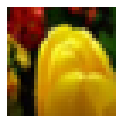

In [ ]:
#generating a random number to display a random image from the dataset along with the label's number and name

rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Shape of image : {}".format(X_train[imageId].shape))
print("Image category number: {}".format(trainData['coarse_labels'][imageId]))
print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))
print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))

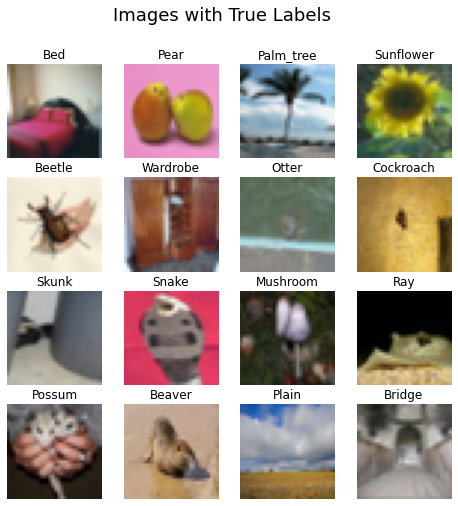

In [ ]:
#16 random images to display at a time along with their true labels
rcParams['figure.figsize'] = 8,8

num_row = 4
num_col = 4

#to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row * num_col)
#imageId

fig, axes = plt.subplots(num_row, num_col)
plt.suptitle('Images with True Labels', fontsize=18)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_train[imageId[k]])
        axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())
        axes[i,j].axis('off')

##Data Pre-processing

In [ ]:
#transforming the testing dataset
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_train = trainData['fine_labels']
#y_train

y_test = testData['fine_labels']
#y_test

Converting class vectors to binary class matrices

In [ ]:
n_classes = 100

y_train = to_categorical(y_train, n_classes)
#y_train

y_test = to_categorical(y_test, n_classes)
#y_test

Splitting the training dataset into training and validation datasets

In [ ]:
#using stratified shuffle split to preserve the percentage of samples in each of the 100 classes
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


Constants

In [ ]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 15
batch_size = 8

In [ ]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

##Custom Data Generator class

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=n_classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch
    

In [ ]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

##Using pre-trained EfficientNetB0

In [6]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
import efficientnet.keras as efn

efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

16804768/16804768 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
__________________________________________

In [ ]:
optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate 
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

In [ ]:
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_data_generator,
                                    validation_data=valid_data_generator,
                                    callbacks=[early_stop, rlrop],
                                    verbose=1,
                                    epochs=epochs)

#saving the trained model weights as data file in .h5 format
model.save_weights("cifar_efficientnetb0_weights.h5")

#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')

Epoch 1/15
5000/5000 [==============================] - 751s 147ms/step - loss: 2.6795 - accuracy: 0.3357 - val_loss: 1.1010 - val_accuracy: 0.6792 - lr: 1.0000e-04
Epoch 2/15
5000/5000 [==============================] - 728s 146ms/step - loss: 1.6417 - accuracy: 0.5488 - val_loss: 0.9064 - val_accuracy: 0.7342 - lr: 1.0000e-04
Epoch 3/15
5000/5000 [==============================] - 712s 142ms/step - loss: 1.3573 - accuracy: 0.6224 - val_loss: 0.8113 - val_accuracy: 0.7698 - lr: 1.0000e-04
Epoch 4/15
5000/5000 [==============================] - 717s 143ms/step - loss: 1.1752 - accuracy: 0.6703 - val_loss: 0.8204 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 5/15
5000/5000 [==============================] - 715s 143ms/step - loss: 1.0496 - accuracy: 0.6980 - val_loss: 0.8079 - val_accuracy: 0.7840 - lr: 1.0000e-04
Epoch 6/15
5000/5000 [==============================] - 706s 141ms/step - loss: 0.9595 - accuracy: 0.7215 - val_loss: 0.7876 - val_accuracy: 0.7898 - lr: 1.0000e-04
Epoch 7/15

In [ ]:
#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


##Making model compatible with tensorflowjs

In [ ]:
#to do
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 2.5 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 16.0 MB 8.3 MB/s 
     |████████████████████████████████| 40 kB 6.7 MB/s 
     |████████████████████████████████| 185 kB 71.9 MB/s 
     |████████████████████████████████| 237 kB 67.9 MB/s 
     |████████████████████████████████| 145 kB 59.5 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 1.7 MB 58.9 MB/s 
     |████████████████████████████████| 5.9 MB 49.4 MB/s 
     |████████████████████████████████| 438 kB 70.4 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Att

In [ ]:
!mkdir carpeta_salida

mkdir: cannot create directory ‘carpeta_salida’: File exists


In [ ]:
!tensorflowjs_converter --input_format keras cifar_efficientnetb0_model.h5 carpeta_salida

2022-11-11 20:42:20.970941: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 20:42:21.621788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-11 20:42:21.621920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-11 20:42:21.621947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you woul

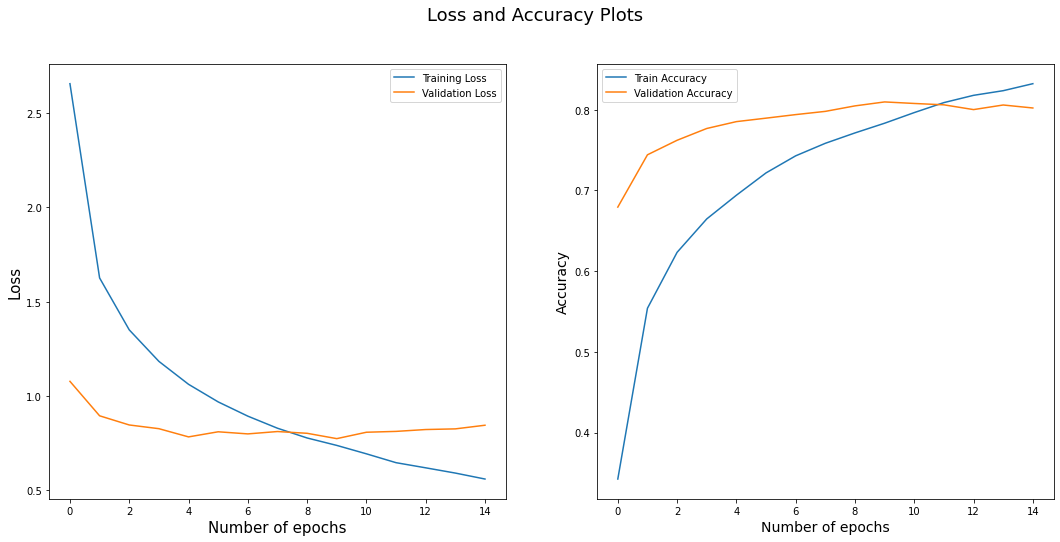

In [ ]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

##Model evaluation

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_generator, verbose=1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

   3/1250 [..............................] - ETA: 35s - loss: 0.9604 - accuracy: 0.7500 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


1250/1250 [==============================] - 25s 20ms/step - loss: 0.7906 - accuracy: 0.8221
Validation Accuracy:  82.21 %


##Model prediction

In [ ]:
y_pred = model.predict_generator(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1250/1250 [==============================] - 23s 17ms/step
Test Accuracy:  81.9 %


##Visualize predictions

In [ ]:
#dataframe of predictions
prediction = pd.DataFrame(y_pred)
prediction.head()

,0
0,68
1,33
2,72
3,51
4,71


True Label: Bed
Predicted Label: Bed


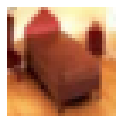

In [ ]:
#generating a random number to display a random image from the dataset along with the true and predicted label
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(subCategory.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

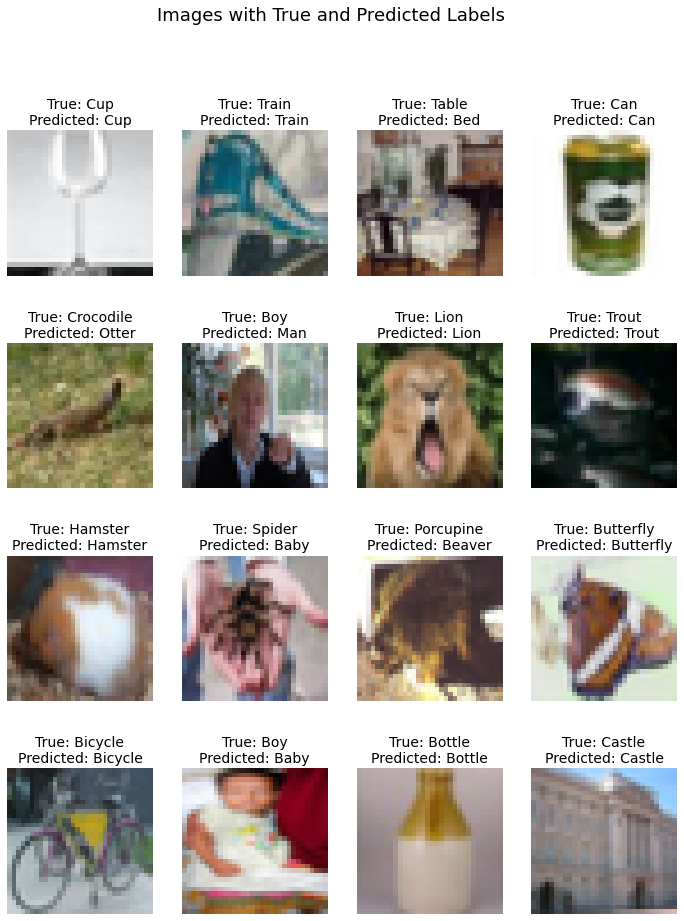

In [ ]:
#16 random images to display at a time along with their true and random labels
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()

##Testing model

In [ ]:
#function to resize the image
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img
    
#resize_test_image('orange.jpeg')

In [ ]:
#resized_img = resize_test_image('orange.jpg')
#np.array([resized_img]).shape

In [ ]:
#function to get prediction for test image from the model
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

#predict_test_image('orange.jpeg')

In [ ]:
predict_test_image('orange.jpg')

1/1 [==============================] - 0s 34ms/step


array([[1.18717710e-02, 3.38518767e-05, 3.81727186e-05, 3.62749088e-05,
        3.31567462e-05, 1.93986798e-05, 4.40570366e-05, 5.12773004e-05,
        1.26671466e-05, 4.80117815e-05, 4.64437733e-04, 9.45169177e-06,
        2.02547490e-05, 9.47042281e-06, 9.04370700e-06, 1.28442698e-04,
        5.44037975e-05, 5.49766337e-05, 9.61609840e-05, 8.74351917e-06,
        3.67746798e-05, 6.82620930e-06, 1.51963304e-05, 1.37832858e-05,
        1.87817022e-05, 4.94521955e-05, 2.13594594e-05, 2.99836802e-06,
        5.39751236e-05, 3.55641969e-05, 1.15311932e-05, 1.67679420e-04,
        2.76492083e-05, 1.09611110e-05, 2.56357271e-05, 1.64869507e-05,
        3.31228075e-05, 1.21751400e-05, 1.09030098e-05, 1.22932077e-04,
        4.03754493e-05, 1.60881973e-06, 1.68482256e-05, 7.02974139e-05,
        1.16688325e-05, 1.15184985e-05, 3.09598545e-05, 1.25518836e-05,
        9.03966247e-06, 2.75763023e-06, 1.24469079e-04, 4.29787068e-03,
        1.49505486e-05, 9.71708059e-01, 5.77505634e-05, 2.918225

In [ ]:
#function to get the sorted prediction
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

#sort_prediction_test_image('orange.jpg')

In [ ]:
sort_prediction_test_image('orange.jpg')

1/1 [==============================] - 0s 23ms/step


array([53,  0, 57, 51, 83, 92, 82, 77, 10, 99, 31, 72, 61, 15, 50, 39, 62,
       94, 18, 89, 74, 43, 60, 78, 54, 17, 63, 16, 28,  7, 25, 71,  9,  6,
       67, 65, 88, 40,  2, 20,  3, 29,  1,  4, 36, 46, 86, 55, 70, 32, 98,
       34, 80, 76, 26, 12,  5, 24, 42, 87, 59, 35, 69, 22, 52, 96, 58, 23,
       66,  8, 47, 79, 37, 84, 44, 30, 45, 64, 33, 38, 90, 91, 68, 13, 11,
       14, 48, 81, 93, 19, 85, 21, 73, 95, 56, 75, 97, 27, 49, 41])

In [ ]:
#function to get the dataframe for top 5 predictions
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(subCategory.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns=['Label', 'Probability'])  
    
    return df

#df_top5_prediction_test_image('orange.jpeg')

In [ ]:
df_top5_prediction_test_image('orange.jpg')['Label'][0]

1/1 [==============================] - 0s 22ms/step


'orange'

In [ ]:
#function to get the plot for top 5 predictions 
def plot_top5_prediction_test_image(test_img):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Prediction", fontsize=18)
    
    new_img = plt.imread(test_img)
    axes[0].imshow(new_img)
    axes[0].axis('off')
    
    data = df_top5_prediction_test_image(test_img)
    x=df_top5_prediction_test_image(test_img)['Label']
    y=df_top5_prediction_test_image(test_img)['Probability']
    
    axes[1] = sns.barplot(x=x, y=y, data=data, color="green")
    
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    
    plt.ylim(0,1.0)
    
    axes[1].grid(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    
    plt.show()

1/1 [==============================] - 0s 32ms/step


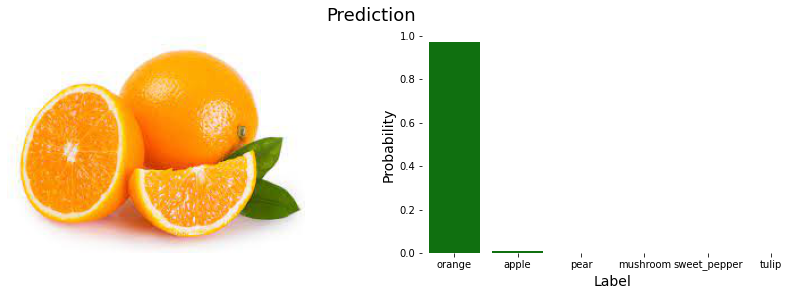

In [ ]:
plot_top5_prediction_test_image('orange.jpg')

1/1 [==============================] - 0s 22ms/step


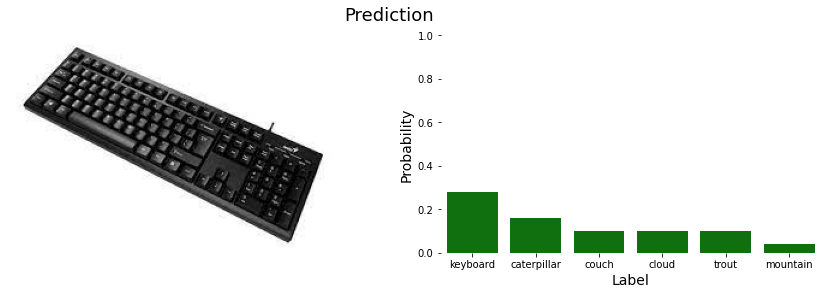

In [ ]:
plot_top5_prediction_test_image('keyboard.jpg')

1/1 [==============================] - 0s 22ms/step


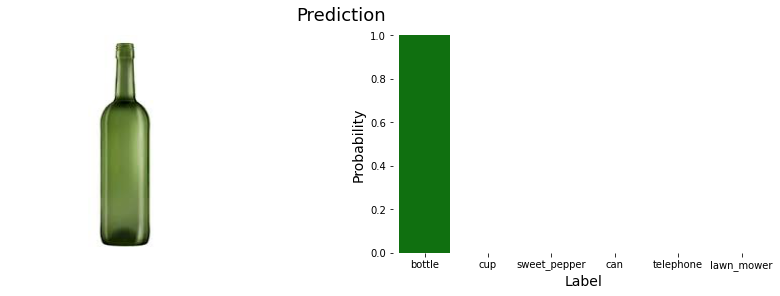

In [ ]:
plot_top5_prediction_test_image('bottle.jpg')

1/1 [==============================] - 0s 22ms/step


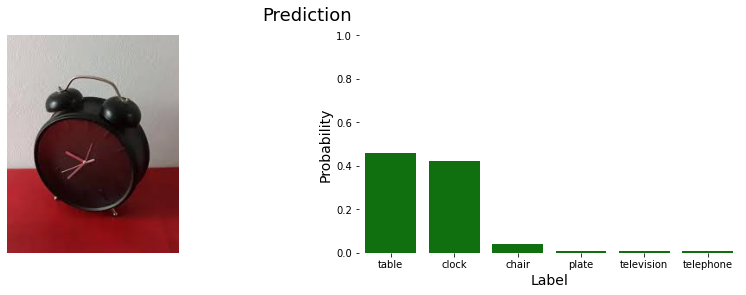

In [ ]:
plot_top5_prediction_test_image('reloj.jpg')

1/1 [==============================] - 0s 48ms/step


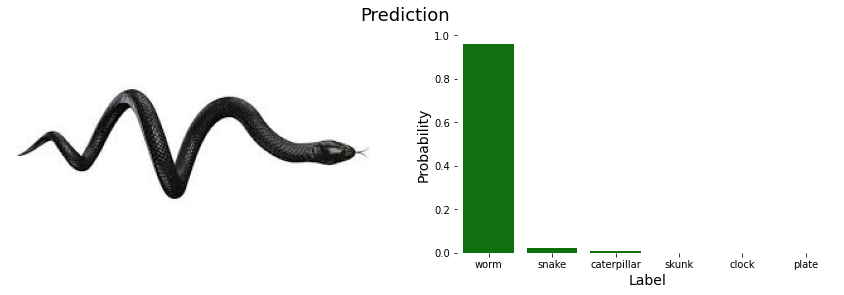

In [ ]:
plot_top5_prediction_test_image('snake.jpg')

1/1 [==============================] - 0s 22ms/step


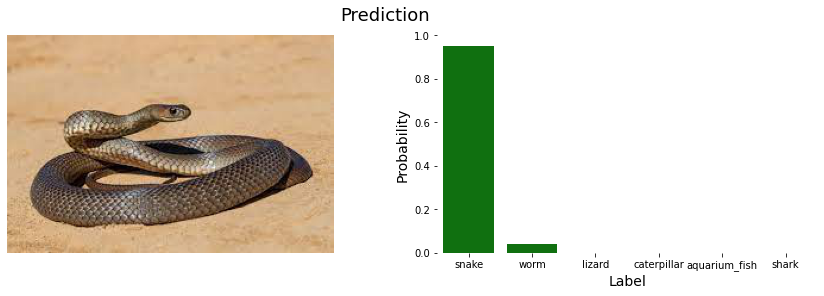

In [ ]:
plot_top5_prediction_test_image('snake.jpg')

In [ ]:
#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')